# Tutorial 11-1: The Denoising Artist – "Cleaning Up Noisy Images"

**Course:** CSEN 342: Deep Learning  
**Topic:** Unsupervised Learning, Autoencoders, and Denoising

## Objective
An **Autoencoder** is a neural network trained to copy its input to its output ($x \to x$). This sounds trivial, but by imposing constraints (like a bottleneck), we force the network to learn efficient data representations.

A **Denoising Autoencoder (DAE)** takes this a step further. We corrupt the input ($	ilde{x}$) and train the network to recover the original ($x$).

$$ \text{Loss} = || g(f(\tilde{x})) - x ||^2 $$

To solve this, the network cannot just memorize; it must learn the **manifold** of valid data points (e.g., what a "shirt" usually looks like) so it can project the noisy input back onto that manifold.

In this tutorial, we will:
1.  **Corrupt Data:** Add Gaussian noise to Fashion-MNIST images.
2.  **Build a CA (Convolutional Autoencoder):** Use Encoder-Decoder architecture with upsampling.
3.  **Train:** Teach the model to remove the noise.

---

## Part 1: Data Preparation & Corruption

We use Fashion-MNIST. We need a helper function to add random noise to the tensors.

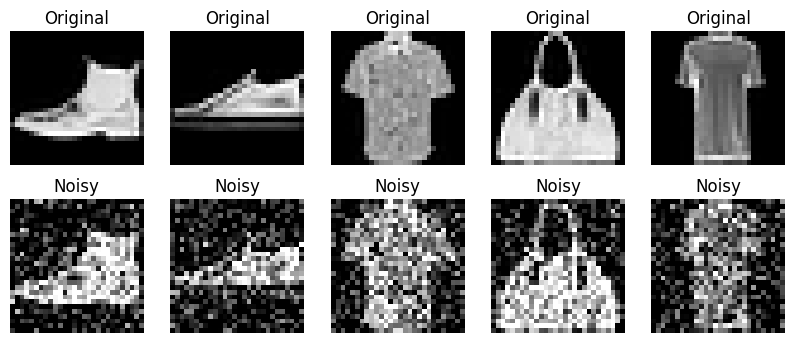

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Load Data
data_root = '../data'
os.makedirs(data_root, exist_ok=True)

transform = transforms.Compose([transforms.ToTensor()])

# robust download
try:
    train_set = torchvision.datasets.FashionMNIST(root=data_root, train=True, download=True, transform=transform)
    test_set = torchvision.datasets.FashionMNIST(root=data_root, train=False, download=True, transform=transform)
except:
    print("Download failed. Please check internet or dataset path.")

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=True)

# 2. Noise Injection Function
def add_noise(images, noise_factor=0.3):
    """
    Adds Gaussian noise to a tensor of images.
    noise_factor: intensity of the noise
    """
    noise = torch.randn_like(images) * noise_factor
    noisy_imgs = images + noise
    # Clip to ensure valid pixel range [0, 1]
    noisy_imgs = torch.clip(noisy_imgs, 0., 1.)
    return noisy_imgs

# Visualize
images, _ = next(iter(test_loader))
noisy = add_noise(images)

plt.figure(figsize=(10, 4))
for i in range(5):
    # Original
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    # Noisy
    plt.subplot(2, 5, i + 6)
    plt.imshow(noisy[i].squeeze(), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')
plt.show()

---

## Part 2: The Convolutional Autoencoder

**Encoder:** 
We use `Conv2d` layers to detect features. We use `Stride=2` or `MaxPool` to downsample the spatial dimensions (compressing information).

**Decoder:**
We use `ConvTranspose2d` layers. These are often called "Deconvolutions". They perform the reverse operation: taking a small feature map and expanding it back to a larger spatial size.

In [2]:
class Denoiser(nn.Module):
    def __init__(self):
        super(Denoiser, self).__init__()
        
        # --- ENCODER ---
        # Input: (Batch, 1, 28, 28)
        self.encoder = nn.Sequential(
            # Conv1: 28x28 -> 28x28
            nn.Conv2d(1, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            # Pool1: 28x28 -> 14x14
            nn.MaxPool2d(2, 2),
            # Conv2: 14x14 -> 14x14
            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.ReLU(),
            # Pool2: 14x14 -> 7x7
            nn.MaxPool2d(2, 2)
        )
        
        # --- DECODER ---
        # Bottleneck Shape: (Batch, 8, 7, 7)
        self.decoder = nn.Sequential(
            # Up1: 7x7 -> 14x14
            nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # Up2: 14x14 -> 28x28
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            # Sigmoid to force output to [0, 1] pixel range
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Denoiser().to(device)
print(model)

Denoiser(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)


---

## Part 3: Training Loop

**Crucial Detail:** The loss function compares the model output to the **clean** image, not the noisy input. We want the model to learn the mapping `Noisy -> Clean`.

We use **MSELoss** (Mean Squared Error), which is standard for image reconstruction tasks.

In [3]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5

print("Starting Training...")

for epoch in range(epochs):
    train_loss = 0.0
    for data in train_loader:
        clean_images, _ = data # We don't care about class labels
        
        # Add noise on the fly
        noisy_images = add_noise(clean_images)
        
        clean_images = clean_images.to(device)
        noisy_images = noisy_images.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(noisy_images)
        
        # Calculate loss against CLEAN images
        loss = criterion(outputs, clean_images)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader):.4f}")

print("Training Complete.")

Starting Training...
Epoch 1, Loss: 0.0293
Epoch 2, Loss: 0.0165
Epoch 3, Loss: 0.0152
Epoch 4, Loss: 0.0145
Epoch 5, Loss: 0.0141
Training Complete.


---

## Part 4: Inference and Visualization

Now let's test the model on unseen test data. We will display:
1.  **Noisy Input:** What the model saw.
2.  **Reconstruction:** What the model predicted (the "cleaned" version).
3.  **Ground Truth:** The original image.

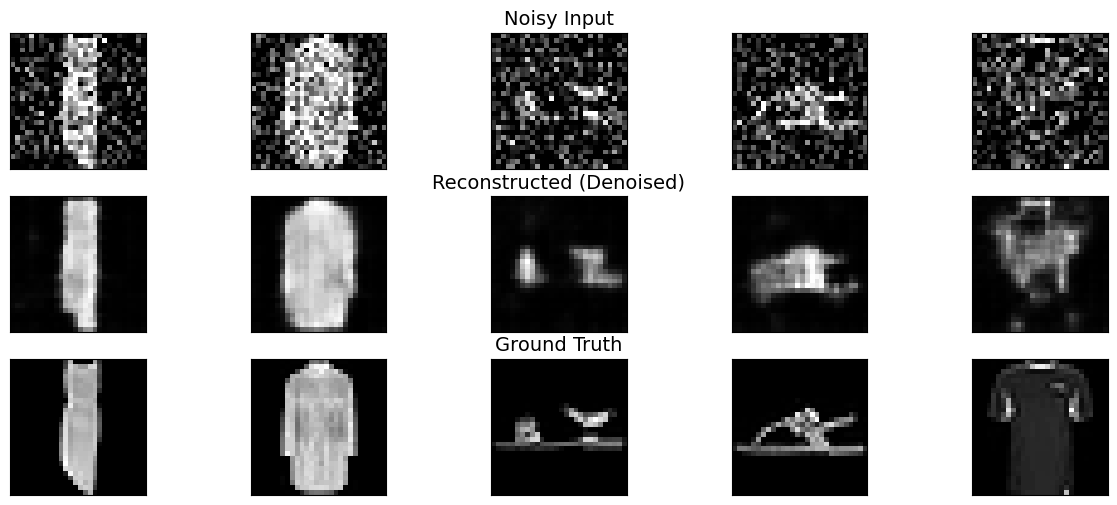

In [4]:
model.eval()

# Get a batch of test images
images, _ = next(iter(test_loader))
noisy_imgs = add_noise(images)

# Move to device
noisy_imgs = noisy_imgs.to(device)

# Forward pass
with torch.no_grad():
    reconstructed = model(noisy_imgs)

# Move back to CPU for plotting
noisy_imgs = noisy_imgs.cpu()
reconstructed = reconstructed.cpu()

# Plotting
plt.figure(figsize=(15, 6))
n_samples = 5

for i in range(n_samples):
    # 1. Noisy Input
    ax = plt.subplot(3, n_samples, i + 1)
    plt.imshow(noisy_imgs[i].squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 2: ax.set_title("Noisy Input", fontsize=14)

    # 2. Reconstructed (Denoised)
    ax = plt.subplot(3, n_samples, i + 1 + n_samples)
    plt.imshow(reconstructed[i].squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 2: ax.set_title("Reconstructed (Denoised)", fontsize=14)

    # 3. Ground Truth
    ax = plt.subplot(3, n_samples, i + 1 + 2*n_samples)
    plt.imshow(images[i].squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 2: ax.set_title("Ground Truth", fontsize=14)

plt.show()

### Discussion

**What did the model learn?**
The model never saw the noise during the "target" phase. To successfully minimize MSE loss, it had to learn that *noise is not a feature of clothes*.

It learned the **manifold** of valid Fashion-MNIST images. When it sees a noisy pixel that doesn't fit the pattern of a "shoe" or "shirt," it smooths it out because that's the best way to get closer to the valid manifold.

**Applications:**
This same principle is used in:
* **Medical Imaging:** Removing grain from MRI/CT scans.
* **Audio:** Removing static from voice recordings.
* **Super-Resolution:** "Denoising" a low-res image into a high-res one.